In [1]:
import os, glob
import csv
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
import plotter
sns.set()

In [2]:
class MyRnn(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
    super(MyRnn, self).__init__()
    self.rnn = nn.RNN(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden)
    self.fc = nn.Linear(hidden_d, out_d)

  def forward(self, x, h0):
    r, h = self.rnn(x, h0)
    y = self.fc(r)  # no activation on the output
    return y, h

In [3]:
s1 = torch.tensor([[4, 15], [4, 14], [4, 13], [4, 12], [4, 11], [4, 10], [4, 9], [4, 8], [4,7], [4, 6], [4, 5], [4, 4], [4, 3], [4, 2]], dtype=torch.float)[:, None, :] 
s2 = torch.tensor([[4, 15], [5,15],[6,15],[7,15],[8,15],[9,15],[10,15],[11, 15],[12, 15],[12,14],[12,13],[12,12],[12,11],[12,10],[12,9],[12,8],[12,7],[12,6],[12,5]],dtype=torch.float)[:, None, :]
# s1 and s2 have 3 dimension

In [4]:
x = torch.cat((s1,s2),dim=0)
print(x.shape)
mu = x.mean(dim=0)
print(mu)
sig=x.std(dim=0)
print(sig)
sequences = [(s1-mu)/sig, (s2-mu)/sig]  # pythonic list to hold sequences of un-even length

torch.Size([33, 1, 2])
tensor([[ 7.5152, 10.5758]])
tensor([[3.6922, 4.1761]])


100%|██████████| 1000/1000 [00:01<00:00, 673.15it/s]


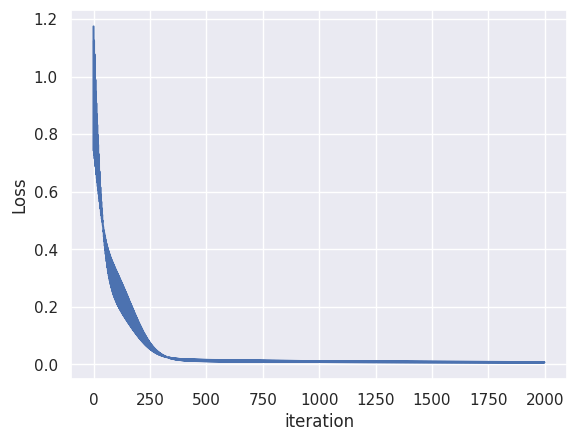

In [5]:
in_d = s1.shape[-1]
out_d = in_d
hidden_d = 8
num_hidden = 1
rnn = MyRnn(in_d, out_d, hidden_d, num_hidden)
loss = []
criterion = nn.MSELoss()
opt = torch.optim.SGD(rnn.parameters(), lr=0.01)
n_epochs = 1000
for e in trange(n_epochs):
  for s in sequences:
    pred, _ = rnn(s[:-1,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # predict next step, init hidden state to zero at the begining of the sequence
    err = criterion(pred, s[1:, ...])  # predict next step for each step
    opt.zero_grad()
    err.backward()
    opt.step()
    loss.append(err.item())
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

In [6]:
rnn.eval()
with torch.no_grad():
  k = 5 
  for si, s in enumerate(sequences):
    pred, h = rnn(s[:k,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # given first k steps predict the next one
    print('seq {}, prev = {}  -> predicted {}th step = {}, actual step = {}'.format(si, s[k-1,...]*sig+mu, k, pred[-1, ...]*sig + mu, s[k, ...]*sig+mu))
    prev = (torch.round(pred[-1:, ...]*sig + mu) - mu) / sig  # round the prediction, attmepting to avoid accumulation of error
    # continue to predict 
    for j in  range(k+1, s.shape[0]):
      pred, h = rnn(prev, h)
      print('\t\tpredicted step {} (prev = {}) = {}, actual step = {}'.format(j, prev*sig+mu, pred[-1,...]*sig+mu, s[j, ...]*sig + mu))
      prev = (torch.round(pred*sig + mu) - mu) / sig
  print('\n')

seq 0, prev = tensor([[ 4., 11.]])  -> predicted 5th step = tensor([[ 3.9104, 10.2964]]), actual step = tensor([[ 4., 10.]])
		predicted step 6 (prev = tensor([[[ 4., 10.]]])) = tensor([[3.7814, 9.0633]]), actual step = tensor([[4., 9.]])
		predicted step 7 (prev = tensor([[[4., 9.]]])) = tensor([[3.7278, 7.8464]]), actual step = tensor([[4., 8.]])
		predicted step 8 (prev = tensor([[[4., 8.]]])) = tensor([[3.7418, 6.6876]]), actual step = tensor([[4., 7.]])
		predicted step 9 (prev = tensor([[[4., 7.]]])) = tensor([[3.8052, 5.6208]]), actual step = tensor([[4., 6.]])
		predicted step 10 (prev = tensor([[[4., 6.]]])) = tensor([[3.9011, 4.6699]]), actual step = tensor([[4., 5.]])
		predicted step 11 (prev = tensor([[[4., 5.]]])) = tensor([[4.0151, 3.8454]]), actual step = tensor([[4., 4.]])
		predicted step 12 (prev = tensor([[[4., 4.]]])) = tensor([[4.1371, 3.1451]]), actual step = tensor([[4., 3.]])
		predicted step 13 (prev = tensor([[[4., 3.]]])) = tensor([[4.2609, 2.5580]]), actual